## This is an example of how to use Hierarchical Agglomerative Clustering Machine Learning (ML) method for quantitative data variables, using Python, Pandas, NumPy, SciPy, Scikit-learn, Pingouin, Matplotlib, Seaborn and Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import pingouin as pg
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

In [2]:
# reading and displaying our dataset
entrance_exam_data = pd.read_excel("entrance_exam.xlsx")
entrance_exam_data

,STUDENT,MATH,PHYSICS,CHEMISTRY
0,Student_A,3.7,2.7,9.1
1,Student_B,7.8,8.0,1.5
2,Student_C,8.9,1.0,2.7
3,Student_D,7.0,1.0,9.0
4,Student_E,3.4,2.0,5.0


In [3]:
entrance_exam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STUDENT    5 non-null      object 
 1   MATH       5 non-null      float64
 2   PHYSICS    5 non-null      float64
 3   CHEMISTRY  5 non-null      float64
dtypes: float64(3), object(1)
memory usage: 292.0+ bytes


In [4]:
entrance_exam_data.describe()

,MATH,PHYSICS,CHEMISTRY
count,5.000000,5.000000,5.000000
mean,6.160000,2.940000,5.460000
std,2.478508,2.918561,3.510413
min,3.400000,1.000000,1.500000
25%,3.700000,1.000000,2.700000
50%,7.000000,2.000000,5.000000
75%,7.800000,2.700000,9.000000
max,8.900000,8.000000,9.100000


In [5]:
# # # This cell script works fine only for local but not for remote .ipynb running...
# # Mounting, and displaying, a 3D scatter graph for each student data
# fig = px.scatter_3d(entrance_exam_data, x="MATH", y="CHEMISTRY", z="PHYSICS", text=entrance_exam_data.STUDENT)
# fig.show()
# # if you're running locally, you can save the html and open as below:
# # fig.write_html('entrance_exam_data_initial.html')
# # reading just saved html local file
# # from IPython.display import IFrame
# # IFrame(src='https://github.com/danielpm1982/sample-ml-clustering/blob/master/entrance_exam_data_initial.html', width=600, height=500)

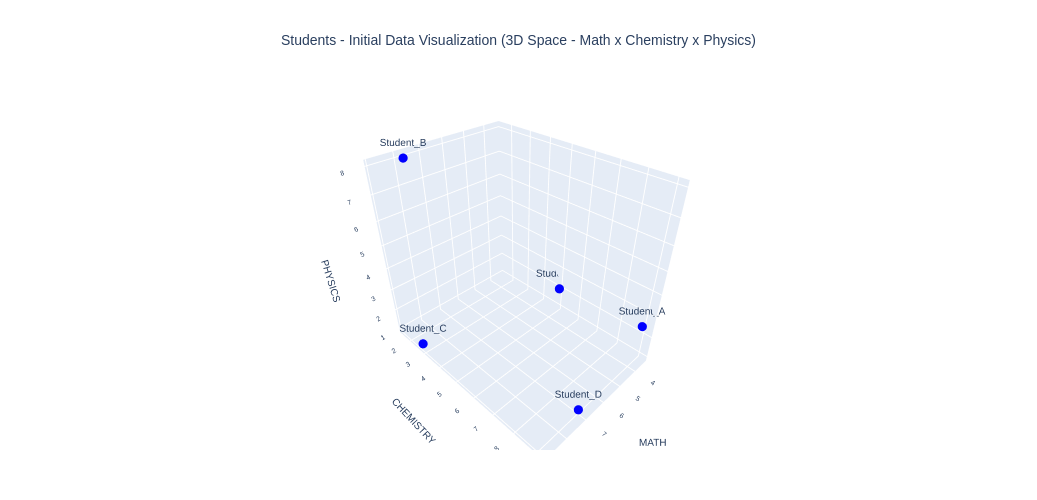

In [6]:
# we can plot the same data and see the observations above, as below - better compatibility with cloud .ipynb running, and 
# works fine locally as well:
pio.renderers.default = "jupyterlab"
import plotly.graph_objects as go
fig = go.Figure()

# ---------- 1. Students scatter ----------
fig.add_trace(go.Scatter3d(
    x=entrance_exam_data["MATH"],
    y=entrance_exam_data["CHEMISTRY"],
    z=entrance_exam_data["PHYSICS"],
    mode='markers+text',
    text=entrance_exam_data["STUDENT"],
    textposition='top center',
    textfont=dict(size=10),
    name="Students",
    marker=dict(size=3, color="blue")
))

# ---------- Layout ----------
fig.update_layout(
    title={
        'text': "Students - Initial Data Visualization (3D Space - Math x Chemistry x Physics)",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=14),
        'pad': dict(t=0, b=0)
    },
    legend=dict(
        itemsizing='constant',  # keeps markers same size as in plot
        font=dict(size=11),     # legend text size
    ),
    scene=dict(
        xaxis=dict(title=dict(text="MATH",font=dict(size=10)),tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="CHEMISTRY",font=dict(size=10)),tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="PHYSICS",font=dict(size=10)),tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(
        l=80,
        r=80,
        t=90,
        b=50
    )
)

# ---------- Save ----------
fig.write_html('entrance_exam_data_initial.html')
fig.show()

In [7]:
# in case we had data measured in different units or very different ranges of data for each variable (discipline), we could 
# have normalized our data using ZScore as below (in our case we don't)
entrance_exam_data_without_student = entrance_exam_data.drop(columns=["STUDENT"])
entrance_exam_data_without_student

,MATH,PHYSICS,CHEMISTRY
0,3.7,2.7,9.1
1,7.8,8.0,1.5
2,8.9,1.0,2.7
3,7.0,1.0,9.0
4,3.4,2.0,5.0


In [8]:
# for normalizing or standardizing our data, we substract from each value the mean value of the column (variable) and divide the 
# result by the sample standard deviation of the same column (variable). That way, we have variables with mean = 0 and standard 
# deviation = 1... each single value varying from -1 up until 1. Then, we proceed the rest of the cluster analysis on that new 
# standardized dataset instead.

![https://github.com/danielpm1982/sample-ml-clustering/blob/master/standardization-Z-score.png?raw=true](https://github.com/danielpm1982/sample-ml-clustering/blob/master/standardization-Z-score.png?raw=true)

In [9]:
# applying the zscore method from scipy.stats module on our original dataset in order to get the standardized new dataset
entrance_exam_data_without_student_std = entrance_exam_data_without_student.apply(func=zscore, ddof=1)
entrance_exam_data_without_student_std

,MATH,PHYSICS,CHEMISTRY
0,-0.992533,-0.082232,1.036915
1,0.661689,1.733731,-1.128072
2,1.105504,-0.664711,-0.786232
3,0.338914,-0.664711,1.008428
4,-1.113573,-0.322076,-0.131039


In [10]:
# showing that the standardized dataset has the mean and std for each variable as 0 and 1, respectively
print(f"standardized dataset mean:\n{round(entrance_exam_data_without_student_std.mean(),2)}\n")
print(f"standardized dataset std:\n{round(entrance_exam_data_without_student_std.std(),2)}")

standardized dataset mean:
MATH         0.0
PHYSICS      0.0
CHEMISTRY   -0.0
dtype: float64

standardized dataset std:
MATH         1.0
PHYSICS      1.0
CHEMISTRY    1.0
dtype: float64


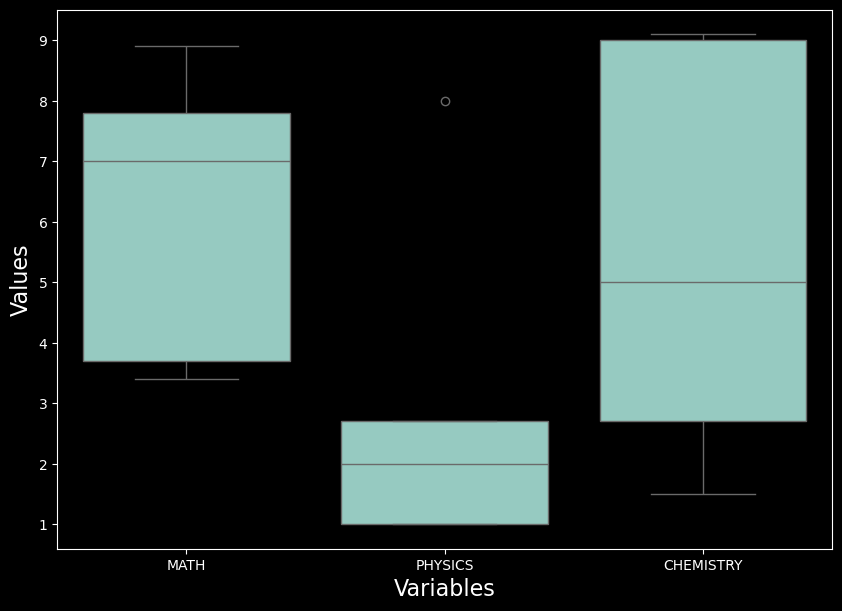

In [11]:
# boxplot for showing the amplitude (range) of all original variables and proving we do not need, in this case, to normalize or 
# standardize the values using ZScore. The amplitude and units of the variables are already quite similar, with values from 0 to 
# 10, with no need of further data treatment
plt.figure(figsize=(10,7))
sns.boxplot(x="variable", y="value", data=pd.melt(entrance_exam_data_without_student))
plt.ylabel("Values",fontsize=16)
plt.xlabel("Variables", fontsize=16)
plt.show()

In [12]:
# creating and showing the dissimilarity matrix for the distance type "euclidean" between students A-B, A-C, A-D, A-E, B-C, B-D, 
# B-E, C-D, C-E, D-E. We don't have to create this matrix explicitly, as, implicitly, it's already created when generating the 
# clusters dendrogram. It's useful though to have a view of the distances between each element's (student) values (disciplines' 
# grades), as it is this distance between values that will be used to determine the sequence at each cluster combination (for 
# single, complete or average linkage types). The distance between students A and B, for instance, using euclidean distance type, 
# is calculated by the square root of the sum of squares of differences between each discipline's grades of student A and student 
# B => A-B = sqroot((3.7-7.8)²+(2.7-8)²+(9.1-1.5)²) = 10.132127. The same calculation is done for all possible combinations between 
# each two students. This distance is later used at each phase of cluster formation, always resulting in the aggregating of two 
# observations (either isolated or previously clustered observations) according to the shortest distance. There are many sorts of
# dissimilarity calculation measures, as well as of linkage types, but the aggregation, ultimately, is always by clustering the 
# shortest distance observations (based on the didssimilarity measure and linkage method chosen).

distance_matrix_euclidean = pdist(entrance_exam_data_without_student, metric="euclidean")
pd.DataFrame(data=[distance_matrix_euclidean], columns=["A-B","A-C","A-D","A-E","B-C","B-D","B-E","C-D","C-E","D-E"], 
             index=["EUCLIDEAN DIST"]).T

,EUCLIDEAN DIST
A-B,10.132127
A-C,8.419620
A-D,3.713489
A-E,4.170132
B-C,7.186793
B-D,10.290287
B-E,8.222530
C-D,6.580274
C-E,6.044833
D-E,5.473573


In [13]:
# options of distance at the "metric" parameter:
# 'braycurtis', 'canberra', 'chebyshev', 'cityblock' (manhattan), 'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
# 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 
# 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
# You can find how they're calculated looking for each one at the web.

![https://github.com/danielpm1982/sample-ml-clustering/blob/master/cluster-aggregation.png?raw=true](https://github.com/danielpm1982/sample-ml-clustering/blob/master/cluster-aggregation.png?raw=true)

In [14]:
# Having decided the method for calculating the dissimilarity distance between each isolated observation (and done the calculus), 
# we must proceed with the cluster formation phases. The aggregation of each two isolated observations between themselves or 
# between one isolated observation and a previous cluster (with more than one observation) is always done considering the shortest 
# distance. In the second case, though, we must also decide what to compare and what distance to consider, as we have more than one 
# observation in a same cluster being compared its distance to the distance of another cluster or isolated observation. In such a 
# case we must chose the linkage method: single linkage, complete linkage or average linkage. For example, on the 2nd Stage above, 
# at the first option, we have a previously formed cluster (A-D) being compared to B. For deciding what distance to consider for 
# such a possible combination, we compare the distances of each observation at the cluster to B, therefore: A-B=10.13 and D-B=10.29. 
# Which distance to consider for this possibility row of Stage II depends on the linkage method we choose. If using single linkage, 
# we choose the min of those two distances, thus, 10.13 - we choose the observation at the cluster that is nearest to the observation 
# outside the cluster, and consider this distance as the distance between the whole cluster and the observation outside. If using 
# the complete linkage method, we choose the max distance between any observation at the previous cluster to the observation 
# outside. In this case, it would be 10.29, instead. Rather, if we're using the average linkage, we take the average distance of all 
# elements at the cluster to the element outside it. In this case, it would be (10.13+10.29)/2=10.21. If the observation outside is 
# another cluster, we should compare each element of both clusters, pair to pair, taking the min, the max or the average of such 
# comparisons as the distance to be considered (the cost) for the row of that aggregation possibility. Then we do the same for the 
# other aggregation possibilities, at that current phase, and finally choose, ALWAYS, the aggregation (row) corresponding to the 
# shortest distance calculated (lowest cost) between the other possibilities. In the case presented here, at the second phase, that 
# would be the 4.17, therefore we aggregate the (A-D) cluster, from phase I, with the E observation, at phase II, at the distance 
# of 4.17. The same for all subsequent phases, until we have only one single cluster with all elements (ADECB) – stage IV. For each 
# aggregation phase concluded, we keep the distance considered for that chosen aggregation row - which is the aggregation cost, 
# calculated according to the chosen linkage method. This aggregation cost is not necessarily any of the values from the 
# dissimilarity distance matrix, although is derived from those (applied at the linkage method). Each dissimilarity distance is 
# between two isolated observations - always, while the distance considered as the aggregation cost may be between two clusters, 
# a cluster and an isolated observation or between two isolated observations as well. Each aggregation phase result, and aggregation 
# distance for that combination, then form the graphical dendrogram below.

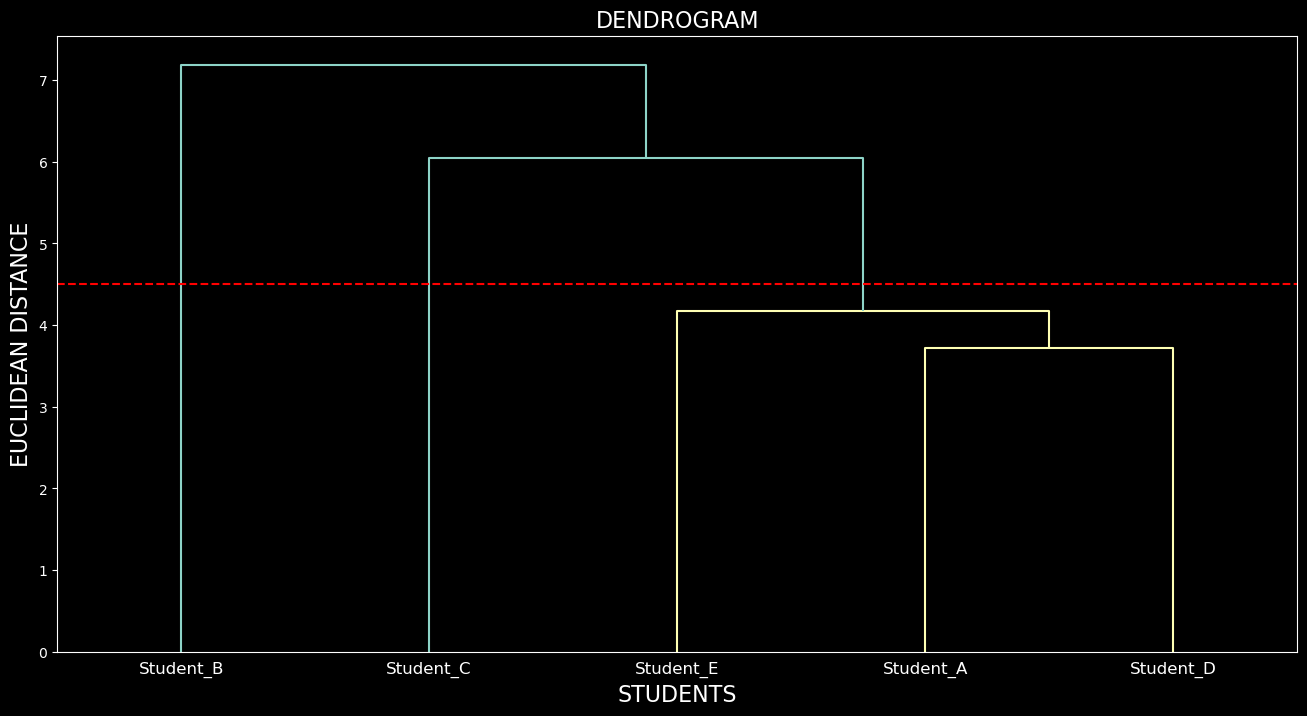

In [15]:
# performing the clustering (graphic solution) and plotting the dendrogram, after setting the distance and linkage type to be used
plt.figure(figsize=(16,8))
dendrogram_euclidean_metric_single_linkage_data_array = sch.linkage(entrance_exam_data_without_student, method="single", metric="euclidean")
dendrogram_s = sch.dendrogram(dendrogram_euclidean_metric_single_linkage_data_array, color_threshold = 4.5, labels = list(entrance_exam_data.STUDENT))
plt.title('DENDROGRAM', fontsize=16)
plt.xlabel('STUDENTS', fontsize=16)
plt.ylabel('EUCLIDEAN DISTANCE', fontsize=16)
plt.axhline(y = 4.5, color = 'red', linestyle = '--')
plt.show()

In [16]:
# at the dendrogram above, based on the distances, it's been evaluated as ideal, for this use case, that we should have 3 clusters, 
# defined by the dashed horizontal red line: [Student_B], [Student_C] and [Student_E, Student_A and Student_D]. The eventual further 
# aggregation between the cluster [Student_C] and the cluster [Student_E, Student_A and Student_D] would be too costly in terms of 
# distance between them, as for the aggregation between [Student_C] and [Student_B]. This decision is subjective, though, and more 
# than one solution could be considered right. As a common sense, if the distance to aggregate the next cluster is too big, we stop 
# the aggregation at that state... in this case, with 3 distinct clusters.

In [17]:
# performing the clustering (numerical solution) and adding a categorical (qualitative) variable to describe which cluster each 
# student belongs to. Although numerical, these are simply categorical labels (identifiers of each cluster). This is done after 
# we have already performed the aggregation and decided how many clusters we wish to keep independent from each other. Below we
# have clusters 0 (with students A, D and E), cluster 1 (with student B) and cluster 2 (with student C). These are excalty the 
# same clusters at the dendrogram above (the order is irrevelant).
cluster_indicator_generator = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'single')
cluster_indicators_generated = cluster_indicator_generator.fit_predict(entrance_exam_data_without_student)
entrance_exam_data['CLUSTER_INDICATOR_SINGLE'] = cluster_indicators_generated
entrance_exam_data['CLUSTER_INDICATOR_SINGLE'] = entrance_exam_data['CLUSTER_INDICATOR_SINGLE'].astype('category')
entrance_exam_data

,STUDENT,MATH,PHYSICS,CHEMISTRY,CLUSTER_INDICATOR_SINGLE
0,Student_A,3.7,2.7,9.1,0
1,Student_B,7.8,8.0,1.5,1
2,Student_C,8.9,1.0,2.7,2
3,Student_D,7.0,1.0,9.0,0
4,Student_E,3.4,2.0,5.0,0


In [18]:
# distances where each cluster has been formed at the dendrogram (at each hierarchical agglomerative stage) (see dendrogram above)
[d[1] for d in dendrogram_s["dcoord"]]

[np.float64(3.713488925525428),
 np.float64(4.170131892398609),
 np.float64(6.044832503882965),
 np.float64(7.1867934435323795)]

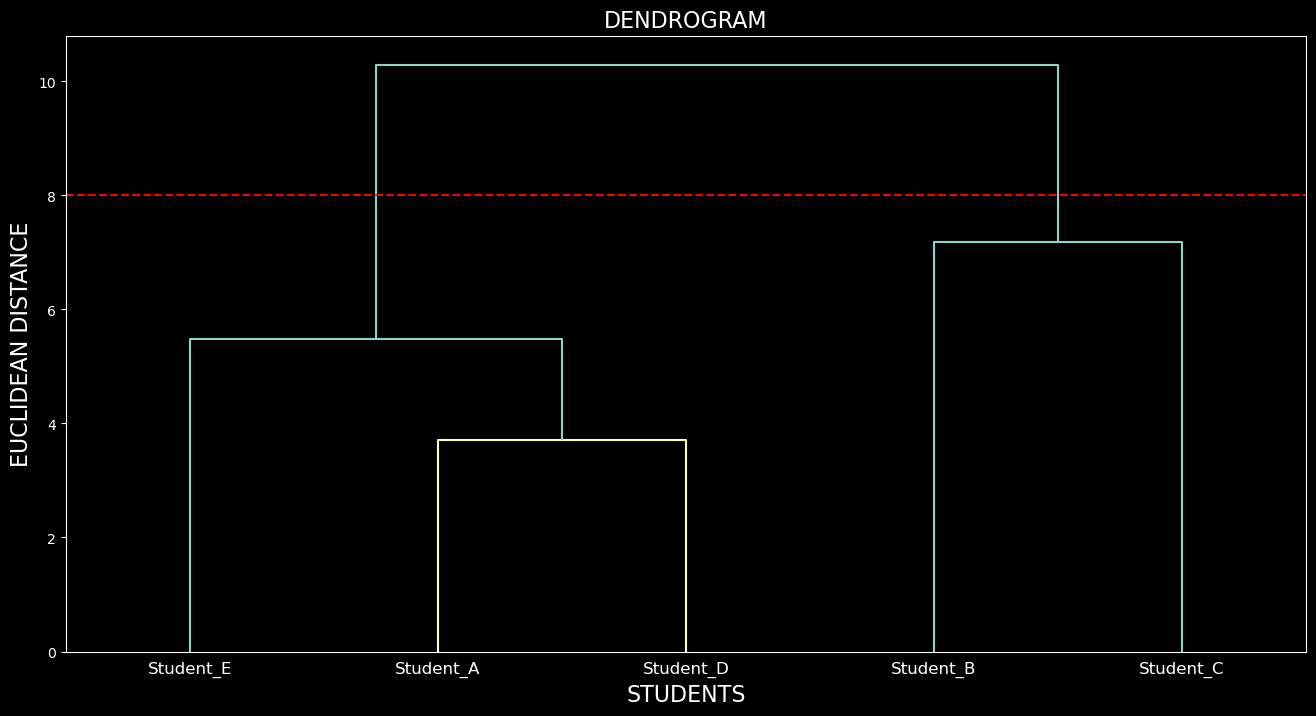

In [19]:
# we can try other linkage types or methods for different clustering results, for instance, changing the linkage method to complete 
# linkage. Generating and plotting the new dendrogram, after setting the distance and linkage type to be used:
plt.figure(figsize=(16,8))
dendrogram_euclidean_metric_single_linkage_data_array = sch.linkage(entrance_exam_data_without_student, method="complete", metric="euclidean")
dendrogram_s = sch.dendrogram(dendrogram_euclidean_metric_single_linkage_data_array, color_threshold = 4.5, labels = list(entrance_exam_data.STUDENT))
plt.title('DENDROGRAM', fontsize=16)
plt.xlabel('STUDENTS', fontsize=16)
plt.ylabel('EUCLIDEAN DISTANCE', fontsize=16)
plt.axhline(y = 8, color = 'red', linestyle = '--')
plt.show()

In [20]:
# if we set the cut off horizontal distance line to 8, we now would have 2 clusters, in this case, and we could also indicate that 
# at our dataframe through cluster indicators. Reusing the same code above, except for changing the linkage type and number of 
# clusters we chose to keep independent from each other. We now have cluster 0 (with students B and C) and cluster 1 (with students
# A, D and E).

In [21]:
cluster_indicator_generator = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'complete')
cluster_indicators_generated = cluster_indicator_generator.fit_predict(entrance_exam_data_without_student)
entrance_exam_data['CLUSTER_INDICATOR_COMPLETE'] = cluster_indicators_generated
entrance_exam_data['CLUSTER_INDICATOR_COMPLETE'] = entrance_exam_data['CLUSTER_INDICATOR_COMPLETE'].astype('category')
entrance_exam_data

,STUDENT,MATH,PHYSICS,CHEMISTRY,CLUSTER_INDICATOR_SINGLE,CLUSTER_INDICATOR_COMPLETE
0,Student_A,3.7,2.7,9.1,0,1
1,Student_B,7.8,8.0,1.5,1,0
2,Student_C,8.9,1.0,2.7,2,0
3,Student_D,7.0,1.0,9.0,0,1
4,Student_E,3.4,2.0,5.0,0,1


In [22]:
# distances where each cluster has been formed at the dendrogram (at each hierarchical agglomerative stage) (see dendrogram above)
[d[1] for d in dendrogram_s["dcoord"]]

[np.float64(3.713488925525428),
 np.float64(5.473572873361603),
 np.float64(7.1867934435323795),
 np.float64(10.290286682109492)]

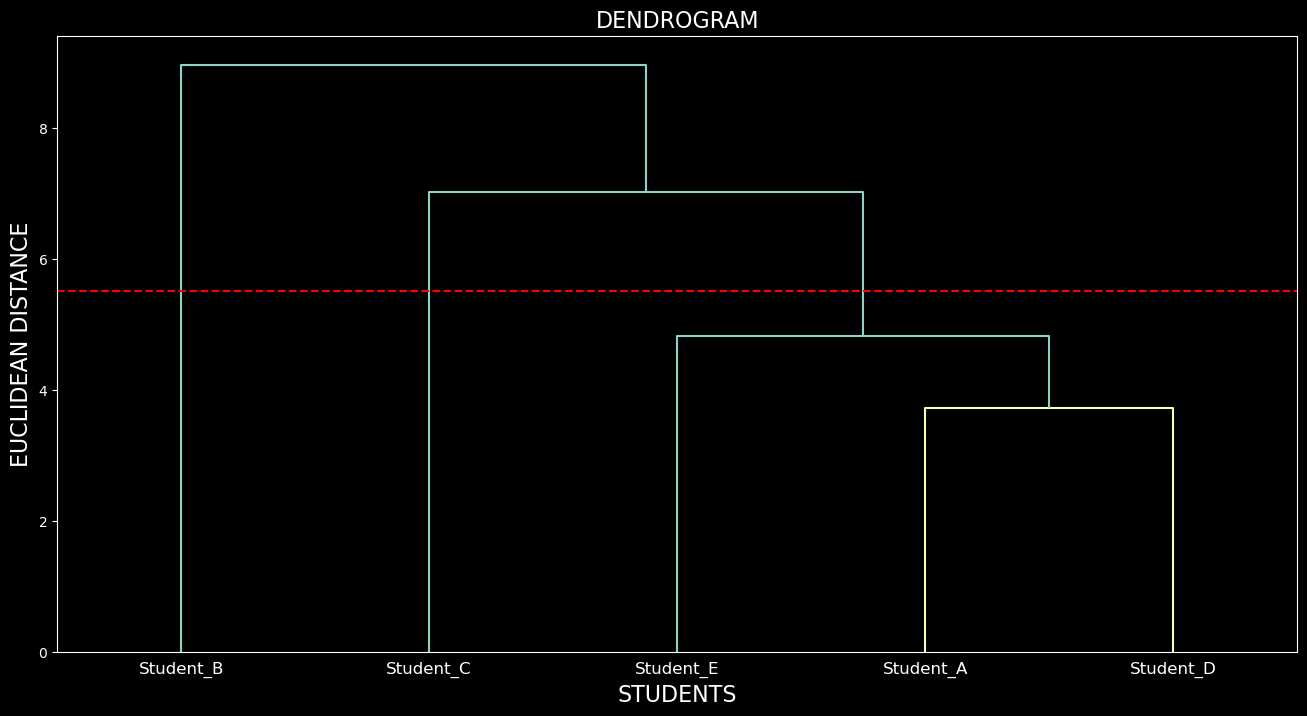

In [23]:
# if we change the linkage method again, now to average linkage, we have another aggregation result and a different dendrogram.
# Generating and plotting the dendrogram, after setting the distance and linkage type to be used:
plt.figure(figsize=(16,8))
dendrogram_euclidean_metric_single_linkage_data_array = sch.linkage(entrance_exam_data_without_student, method="average", metric="euclidean")
dendrogram_s = sch.dendrogram(dendrogram_euclidean_metric_single_linkage_data_array, color_threshold = 4.5, labels = list(entrance_exam_data.STUDENT))
plt.title('DENDROGRAM', fontsize=16)
plt.xlabel('STUDENTS', fontsize=16)
plt.ylabel('EUCLIDEAN DISTANCE', fontsize=16)
plt.axhline(y = 5.5, color = 'red', linestyle = '--')
plt.show()

In [24]:
# if we set the cut off horizontal distance line to 5.5, we now would have 3 clusters, in this case, and we could also indicate that 
# at our dataframe through cluster indicators. Reusing the same code above, except for changing the linkage type and number of 
# clusters we chose to keep independent from each other. We now have cluster 0 (with students A, D and E), cluster 1 (with student
# B) and cluster 2 (with student C). Coincidently equal to when we used single linkage, but differently from when we used the 
# complete linkage.

In [25]:
cluster_indicator_generator = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'average')
cluster_indicators_generated = cluster_indicator_generator.fit_predict(entrance_exam_data_without_student)
entrance_exam_data['CLUSTER_INDICATOR_AVERAGE'] = cluster_indicators_generated
entrance_exam_data['CLUSTER_INDICATOR_AVERAGE'] = entrance_exam_data['CLUSTER_INDICATOR_AVERAGE'].astype('category')
entrance_exam_data

,STUDENT,MATH,PHYSICS,CHEMISTRY,CLUSTER_INDICATOR_SINGLE,CLUSTER_INDICATOR_COMPLETE,CLUSTER_INDICATOR_AVERAGE
0,Student_A,3.7,2.7,9.1,0,1,0
1,Student_B,7.8,8.0,1.5,1,0,1
2,Student_C,8.9,1.0,2.7,2,0,2
3,Student_D,7.0,1.0,9.0,0,1,0
4,Student_E,3.4,2.0,5.0,0,1,0


In [26]:
# distances where each cluster has been formed at the dendrogram (at each hierarchical agglomerative stage) (see dendrogram above)
[d[1] for d in dendrogram_s["dcoord"]]

[np.float64(3.713488925525428),
 np.float64(4.821852382880106),
 np.float64(7.014908666114838),
 np.float64(8.957934317775708)]

In [27]:
# Dissimilarity distances (according to each method chosen), as well as the variables' values, do not change when we use different 
# linkage methods. What may vary is the aggregation distance at each phase (the aggregation cost), the number of phases and the
# dendrogram and final matrix with the output of the clustering, as the clusters might be different in number and in elements 
# composing them.